In [1]:
%matplotlib inline
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from scipy import special, ndimage
from PIL import Image
import simplejson as json

In [2]:
raster = rasterio.open('srtm_37_04.tif')
height = raster.read(1).astype(float)

In [3]:
left, bottom, right, top = list(raster.bounds)

In [4]:
min_height = 0
max_height = np.max(height)

step = 254./(max_height-min_height) # we save zero for the sea

In [5]:
filtered_height = np.copy(height)
filtered_height[height<min_height] = 0
filtered_height = ndimage.gaussian_filter(filtered_height,sigma = 5)

In [6]:
gy,gx = np.gradient(filtered_height)
filtered_height[height<min_height] = 0

In [7]:
def discretize(orig_values, nbins=256, step = 100):
    real_nbins = nbins
    for i in range(20):
        centers = np.linspace(.5/real_nbins,100-.5/real_nbins,real_nbins)
        vals = np.percentile(orig_values[::step],centers)
        unique_vals = np.unique(vals)
        real_nbins = real_nbins*nbins/len(unique_vals)
    unique_vals, keys = np.unique(vals, return_index=True)
    discretized = np.digitize( orig_values, bins = (unique_vals[1:]+unique_vals[:-1])/2)
    return discretized, vals[keys]

In [8]:
disc_gx, dict_gx = discretize(gx)
disc_gy, dict_gy = discretize(gy)
disc_h, dict_h = discretize(filtered_height)

In [9]:
join = np.moveaxis(np.array([disc_h,disc_gx,disc_gy]),0,-1).astype(np.uint8)

In [10]:
img = Image.fromarray(join[::3,::3])
img.save('compressed.png')

In [11]:
dict_values = {
    'height': list(np.round(dict_h,2)),
    'gx': list(np.round(dict_gx,2)),
    'gy': list(np.round(dict_gy,2)),
    'left':left,
    'bottom':bottom,
    'right':right,
    'top':top
}

In [12]:
with open('comp_dict.json','w') as f:
    json.dump(dict_values, f)

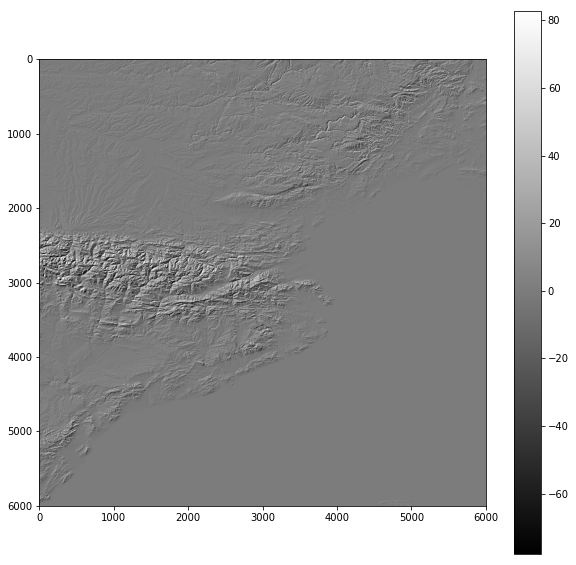

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(gx+gy,cmap='gray');
plt.colorbar()